# About

Numerical plots pertaining to trials of a simplified 2-dim Kuramoto system with adaptive delays and no self-feedback links. Requires a folder of .mat files from the the following scripts:
 - script2D_iter.m

Uses the following packages and functions:

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files (for fig.4d)
import_folder = 'sec4_2D_4'
export_folder = 'export'
ex_name = 'sec4_2D_num'

# Directory
dir_main = os.getcwd()
dir_im = os.path.join(dir_main, 'matlab', 'data', import_folder)
dir_ex = os.path.join(dir_main, 'matlab', 'data', export_folder)

filenames = os.listdir(dir_im)

# Import and compile data

## Constant parameters

In [3]:
dir_sam = os.path.join(dir_im, filenames[0])
dict_mat = sio.loadmat(dir_sam)

param = {'g': dict_mat['g'][0,0],
         'omega0': dict_mat['omega0'][0,0],
         'gain': dict_mat['gain'][0,0],
         'tf': dict_mat['tf'][0,0],
         'tau0': dict_mat['tau0'][0,0],
         }

# Asymptotic percentage
asy = 0.25

## Asymptotic values

In [4]:
# Compiled arrays
init_freqs = np.zeros(len(filenames))
init_Deltas = np.zeros(len(filenames))
asy_freqs = np.zeros(len(filenames))
asy_Deltas = np.zeros(len(filenames))
var_freqs = np.zeros(len(filenames))

trial1_freq = 0.4
trial1_Delta = 0.4

trial2_freq = 0.8
trial2_Delta = 0.8

trial1_file = ''
trial2_file = ''

trial1_color = 'purple'
trial2_color = 'orange'

min_DIST1 = 100
min_DIST2 = 100

for i in range(len(filenames)):
    
    # Import .mat file
    dir_mat = os.path.join(dir_im, filenames[i])
    dict_mat = sio.loadmat(dir_mat)
    
    # Compile solution dictionary
    sol = {'t': np.reshape(dict_mat['t'], -1),
           'y': dict_mat['y'],
           'yp': dict_mat['yp'],
           'tau': dict_mat['tau'],
           'taup': dict_mat['taup']
          }
    
    init_freq = dict_mat['init_freq'][0,0]
    init_Delta = dict_mat['Delta0'][0,0]
    
    # Compute the global frequency:
    arr_omega = asylib.weight_avg(sol['t'], sol['yp'], asy)
    asy_Omega = np.sum(arr_omega) / arr_omega.size

    Omega_vars = asylib.weight_avg(sol['t'], (sol['yp'] - asy_Omega)**2, asy)
    Omega_var = np.sum(Omega_vars)

    # Get array of asymptotic phases:
    arr_lin = asy_Omega*sol['t']
    arr_lin = arr_lin[:,None]

    arr_phases = sol['y'] - arr_lin
    asy_phases = asylib.weight_avg(sol['t'], arr_phases, asy)
    asy_Delta = np.abs(asy_phases[1] - asy_phases[0])
    
    # Variance
    phase_vars = asylib.weight_avg(sol['t'], (arr_phases - asy_phases)**2, asy)
    phase_var = np.sum(phase_vars)
    
    # Distances
    DIST1 = np.sqrt((init_freq - trial1_freq)**2 + (init_Delta - trial1_Delta)**2)
    DIST2 = np.sqrt((init_freq - trial2_freq)**2 + (init_Delta - trial2_Delta)**2)
    
    if DIST1 < min_DIST1:
        min_DIST1 = DIST1
        trial1_file = filenames[i]
    
    if DIST2 < min_DIST2:
        min_DIST2 = DIST2
        trial2_file = filenames[i]
        
    # SAVE TO ARRAYS
    init_freqs[i] = init_freq
    init_Deltas[i] = init_Delta
    asy_freqs[i] = asy_Omega
    asy_Deltas[i] = asy_Delta
    var_freqs[i] = Omega_var
    
    # Print statements:
    # print("Trial: " + filenames[i] + ', asy. freq = ' + str(asy_Omega))

## Theoretical asy values

In [5]:
Omega_fun = lambda Omega: funlib.Omega2D(Omega, param)[0]
Delta_fun = lambda Omega: funlib.Omega2D(Omega, param)[1]

# Parameters
w0 = param['omega0']
g = param['g']
tau0 = param['tau0']

# Get all roots of Omega_fun in region
Omega_roots = rootlib.root_on_interval(Omega_fun, w0-g/2, w0+g/2, steps=500)
Delta_roots = np.zeros(Omega_roots.size)

for i in range(Omega_roots.size):
    Delta_roots[i] = Delta_fun(Omega_roots[i])

## Export

In [6]:
# Define export dictionary
ex_mat = {'eq_freqs': Omega_roots,
          'eq_Deltas': Delta_roots,
          'init_freqs': init_freqs,
          'init_Deltas': init_Deltas,
          'asy_freqs': asy_freqs,
          'asy_Deltas': asy_Deltas,
          'var_freqs': var_freqs,
          'g': param['g'],
          'w0': param['omega0'],
          'tau0': param['tau0']
          }

# Copy parameters
for par in param.keys():
    ex_mat[par] = param[par]

# Export to .mat (export folder)
dir_exfile = os.path.join(dir_ex, ex_name)
sio.savemat(dir_exfile, ex_mat)

# Arrays over time

Skip to this cell if asymptotic arrays have already been processed.

In [7]:
# Import from folder2 with at least two trials (converging to different frequencies
trial1 = {'color': trial1_color, 'name': trial1_file}
trial2 = {'color': trial2_color, 'name': trial2_file}

tf_show = 5000 # Display up to time t = tf_show seconds.

### Trial 1

In [8]:
dir_mat1 = os.path.join(dir_im, trial1['name'])
dict_mat1 = sio.loadmat(dir_mat1)

trial1['t'] = np.reshape(dict_mat1['t'], -1)
trial1['y'] = dict_mat1['y']
trial1['yp'] = dict_mat1['yp']
trial1['tau'] = dict_mat1['tau']
trial1['init_freq'] = dict_mat1['init_freq'][0,0]
trial1['Delta0'] = dict_mat1['Delta0'][0,0]

# Compute the asymptotic arrays
arr_omega1 = asylib.weight_avg(trial1['t'], trial1['yp'], asy)
asy_Omega1 = np.sum(arr_omega1) / arr_omega1.size


sol1 = {'t': np.reshape(dict_mat1['t'], -1),
       'y': dict_mat1['y'],
       'yp': dict_mat1['yp'],
       'tau': dict_mat1['tau'],
       'taup': dict_mat1['taup']
      }

# Get array of asymptotic phases:
arr_lin1 = asy_Omega1*sol1['t']
arr_lin1 = arr_lin1[:,None]

arr_phases1 = trial1['y'] - arr_lin1
asy_phases1 = asylib.weight_avg(trial1['t'], arr_phases1, asy)
asy_Delta1 = np.abs(asy_phases1[1] - asy_phases1[0])

# Store
trial1['phases'] = arr_phases1
trial1['asy_phases'] = asy_phases1
trial1['asy_Omega'] = asy_Omega1

### Trial 2

In [9]:
dir_mat2 = os.path.join(dir_im, trial2['name'])
dict_mat2 = sio.loadmat(dir_mat2)

trial2['t'] = np.reshape(dict_mat2['t'], -1)
trial2['y'] = dict_mat2['y']
trial2['yp'] = dict_mat2['yp']
trial2['tau'] = dict_mat2['tau']
trial2['init_freq'] = dict_mat2['init_freq'][0,0]
trial2['Delta0'] = dict_mat2['Delta0'][0,0]

# Compute the asymptotic arrays
arr_omega2 = asylib.weight_avg(trial2['t'], trial2['yp'], asy)
asy_Omega2 = np.sum(arr_omega2) / arr_omega2.size


sol2 = {'t': np.reshape(dict_mat2['t'], -1),
       'y': dict_mat2['y'],
       'yp': dict_mat2['yp'],
       'tau': dict_mat2['tau'],
       'taup': dict_mat2['taup']
      }

# Get array of asymptotic phases:
arr_lin2 = asy_Omega2*sol2['t']
arr_lin2 = arr_lin2[:,None]

arr_phases2 = trial2['y'] - arr_lin2
asy_phases2 = asylib.weight_avg(trial2['t'], arr_phases2, asy)
asy_Delta2 = np.abs(asy_phases2[1] - asy_phases2[0])

# Store
trial2['phases'] = arr_phases2
trial2['asy_phases'] = asy_phases2
trial2['asy_Omega'] = asy_Omega2

# Asymptotic arrays

In [10]:
# Import arrays and values
dir_exfile = os.path.join(dir_ex, ex_name)
dict_ex = sio.loadmat(dir_exfile)

eq_freqs = np.reshape(dict_ex['eq_freqs'], -1)
eq_Deltas = np.reshape(dict_ex['eq_Deltas'], -1)
init_freqs = np.reshape(dict_ex['init_freqs'], -1)
init_Deltas = np.reshape(dict_ex['init_Deltas'], -1)
asy_freqs = np.reshape(dict_ex['asy_freqs'], -1)
asy_Deltas = np.reshape(dict_ex['asy_Deltas'], -1)

# Group arrays based on asymptotics
inds1 = np.array([], dtype='int64')
inds2 = np.array([], dtype='int64')

tol = 0.05

max_DIST = 0
for k in range(init_freqs.size):
    DIST1 = np.abs(asy_Omega1 - asy_freqs[k])
    if DIST1 < tol:
        inds1 = np.append(inds1, k)
        max_DIST = max(max_DIST, DIST1)
    
    DIST2 = np.abs(asy_Omega2 - asy_freqs[k])
    if DIST2 < tol:
        inds2 = np.append(inds2, k)
        max_DIST = max(max_DIST, DIST2)

# Plot

## Options

In [11]:
# Plot positions [left, bottom, width, height] 
bbox0 = [0.15, 0.7, 0.35, 0.20]  # Fig 2a: Derivative plots
bbox1 = [0.15, 0.4, 0.35, 0.20]  # Fig 2b: sin(phase) plots
bbox2 = [0.15, 0.1, 0.35, 0.20] # Fig 2c: Delay plots
bbox3 = [0.60, 0.1, 0.45, 0.8] # Fig 2d: Iterated trial plot

# Figure a,b,c lines
line_opts = {'linewidth': 1.8,
             'alpha': 0.9
            }

ls1 = (0, (5,1))
ls2 = (1, (1,1))
ls3 = (1, (1,2))

tf = np.max(trial1['t'])

# Dotted lines (linking initial to asy points in fig.d)
dotopts = {'linestyle': '-',
           'linewidth': 0.7,
           'marker': None,
           'alpha': 0.5
          }

omega_opts = {'linewidth': 1.2,
              'linestyle': 'solid',
              'alpha': 0.8,
              'color': 'green'
              }

alp_init = 0.8

initsize = 25
initsize2 = 125
starsize = 125
starsize2 = 200

num_plot = int(init_freqs.size)
freq_absmax = np.max(np.abs(init_freqs - dict_ex['w0']))

## Generate figure

(0.0, 5000)

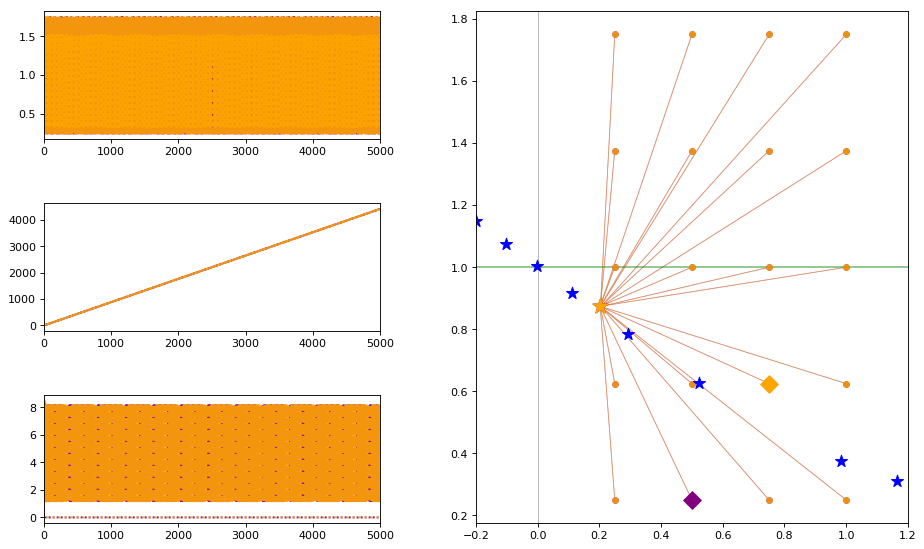

In [12]:
fig, ax = plt.subplots(4, figsize=(12,8), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)

# Trial 1:
ax[0].plot(trial1['t'], trial1['yp'][:,0], color=trial1['color'], linestyle=ls1, **line_opts)
ax[1].plot(trial1['t'], trial1['y'][:,0], color=trial1['color'], linestyle=ls1, **line_opts)
ax[2].plot(trial1['t'], trial1['tau'][:,0], color=trial1['color'], linestyle=ls1, **line_opts)

ax[0].plot(trial1['t'], trial1['yp'][:,1], color=trial1['color'], linestyle=ls2, **line_opts)
ax[1].plot(trial1['t'], trial1['y'][:,1], color=trial1['color'], linestyle=ls2, **line_opts)
ax[2].plot(trial1['t'], trial1['tau'][:,1], color=trial1['color'], linestyle=ls2, **line_opts)

# Trial 2:
ax[0].plot(trial2['t'], trial2['yp'][:,0], color=trial2['color'], linestyle=ls1, **line_opts)
ax[1].plot(trial2['t'], trial2['y'][:,0], color=trial2['color'], linestyle=ls1, **line_opts)
ax[2].plot(trial2['t'], trial2['tau'][:,0], color=trial2['color'], linestyle=ls1, **line_opts)

ax[0].plot(trial2['t'], trial2['yp'][:,1], color=trial2['color'], linestyle=ls3, **line_opts)
ax[1].plot(trial2['t'], trial2['y'][:,1], color=trial2['color'], linestyle=ls3, **line_opts)
ax[2].plot(trial2['t'], trial2['tau'][:,1], color=trial2['color'], linestyle=ls3, **line_opts)

ax[0].axhline(y=dict_ex['w0'], zorder=-1, **omega_opts)
ax[0].axhline(y=asy_Omega1, color='black', alpha=0.5, linewidth=0.5, zorder=-2)

# Figure D:

# Group 1:
for j in range(inds1.size):
    
    p1 = np.array([init_Deltas[inds1[j]], asy_Deltas[inds1[j]]])
    p2 = np.array([init_freqs[inds1[j]], asy_freqs[inds1[j]]]) 
    ax[3].plot(p1, p2, color=trial1['color'], **dotopts, zorder=-2)

ax[3].scatter(init_Deltas[inds1], init_freqs[inds1], color=trial1['color'], s=initsize, alpha=alp_init, zorder=-1)
ax[3].scatter(np.array([asy_Delta1]), np.array([asy_Omega1]), color=trial1['color'], marker='*', s=starsize2, zorder=0) 

for j in range(inds2.size):
    
    p1 = np.array([init_Deltas[inds2[j]], asy_Deltas[inds2[j]]])
    p2 = np.array([init_freqs[inds2[j]], asy_freqs[inds2[j]]]) 
    ax[3].plot(p1, p2, color=trial2['color'], **dotopts, zorder=-2)

ax[3].scatter(init_Deltas[inds2], init_freqs[inds2], color=trial2['color'], s=initsize, alpha=alp_init, zorder=-1)
ax[3].scatter(asy_Delta2, asy_Omega2, color=trial2['color'], marker='*', s=starsize2, zorder=0) 

ax[3].scatter(eq_Deltas, eq_freqs, color='blue', marker='*', s=starsize, zorder=1)

ax[3].scatter(trial1['Delta0'], trial1['init_freq'], color=trial1['color'], s=initsize2, marker='D', zorder=0)
ax[3].scatter(trial2['Delta0'], trial2['init_freq'], color=trial2['color'], s=initsize2, marker='D', zorder=0)

ax[3].axhline(y=dict_ex['w0'], color='green', alpha=0.5, zorder=-2)
ax[3].axvline(x=0, color='black', alpha=0.5, linewidth=0.5, zorder=-2)

ax[3].set_xlim(left= -0.2*np.max(init_Deltas), right=1.2*np.max(init_Deltas))
ax[3].set_ylim(bottom=dict_ex['w0'] - 1.1*freq_absmax, top=dict_ex['w0'] + 1.1*freq_absmax)

# Adjustments to axes
ax[0].set_xlim(left=np.min(trial1['t']), right=tf_show)
ax[1].set_xlim(left=np.min(trial1['t']), right=tf_show)
ax[2].set_xlim(left=np.min(trial1['t']), right=tf_show)

In [13]:
print(trial1['color'] + ' freq: ' + str(trial1['asy_Omega']) + ', initial phase diff: ' + str(trial1['Delta0']))
print(trial2['color'] + ' freq: ' + str(trial2['asy_Omega']) + ', initial phase diff: ' + str(trial2['Delta0']))

purple freq: 0.8741306170539014, initial phase diff: 0.5
orange freq: 0.8735323348609463, initial phase diff: 0.75


In [14]:
max_DIST, asy_Delta1, asy_Delta2, trial1['init_freq'], trial2['init_freq']

(0.001528961608199264, 0.20250835302413606, 0.2037168300504959, 0.25, 0.625)

In [15]:
trial1['y'][:,1] - trial1['yp'][:,1] * trial1['t']

array([5.00000000e-01, 4.99999920e-01, 4.99999920e-01, ...,
       2.76155945e+03, 2.61225988e+03, 2.48764532e+03])

In [16]:
trial1['t']

array([0.00000000e+00, 1.49937667e-05, 2.99875334e-05, ...,
       4.99875675e+03, 4.99970179e+03, 5.00000000e+03])

In [17]:
arr_omega1[0]

0.8714236982095476